In [227]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [228]:
import pandas as  pd
df=pd.read_csv(r'/content/drive/My Drive/PRACTICE/2022SepCustomerProject/Marketing_campaign.csv',sep='\t')

In [229]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [230]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
import sys
import os
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


Features in Dataset

People
ID: Customer's unique identifier
Year_Birth: Customer's birth year
Education: Customer's education level
Marital_Status: Customer's marital status
Income: Customer's yearly household income
Kidhome: Number of children in customer's household
Teenhome: Number of teenagers in customer's household
Dt_Customer: Date of customer's enrollment with the company
Recency: Number of days since customer's last purchase
Complain: 1 if the customer complained in the last 2 years, 0 otherwise
Products
MntWines: Amount spent on wine in last 2 years
MntFruits: Amount spent on fruits in last 2 years
MntMeatProducts: Amount spent on meat in last 2 years
MntFishProducts: Amount spent on fish in last 2 years
MntSweetProducts: Amount spent on sweets in last 2 years
MntGoldProds: Amount spent on gold in last 2 years
Promotion
NumDealsPurchases: Number of purchases made with a discount
AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
Response: 1 if customer accepted the offer in the last campaign, 0 otherwise
Place
NumWebPurchases: Number of purchases made through the company’s website
NumCatalogPurchases: Number of purchases made using a catalogue
NumStorePurchases: Number of purchases made directly in stores
NumWebVisitsMonth: Number of visits to company’s website in the last month


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [232]:
print(f'Dataset size: {df.shape}')

Dataset size: (2240, 29)


# New section

FEATURE GENERATION FOR MODEL 


In [233]:
#Calculating Age using Date of birth
df['Age'] = datetime.now().year - df['Year_Birth']  # Client Age

In [234]:
def get_different_year():
    registration_year = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y').apply(lambda x: x.year)
    current_year = datetime.now().year
    return current_year - registration_year

df['Years_Since_Registration'] = get_different_year()  # Number of years since customer registration

In [235]:
df["Education"] = df["Education"].replace({"Basic": 0, "Graduation": 1, "2n Cycle": 2, "Master": 2, "PhD": 3})
# Encoded in numbers in order

In [236]:
df['Marital_Status'] = df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone",
    "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

step_2 = df['Marital_Status'].replace({'Alone': 1, 'Partner': 2})

df["Family_Size"] = step_2 + df['Kidhome'] + df['Teenhome']  # Total number of people in the family

df = pd.concat([df, pd.get_dummies(df['Marital_Status'])], axis=1)  # Separate features for Alone and Partner

In [237]:
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Sum_Mnt'] = df[mnt_cols].sum(axis=1)  # Total amount spent on products

In [238]:
accepted_cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                     'Response']
df['Num_Accepted_Cmp'] = df[accepted_cmp_cols].sum(axis=1)  
# Number of companies in which the client accepted the offer

In [239]:
total_purchases = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Num_Total_Purchases'] = df[total_purchases].sum(axis=1)  # Total number of purchases

                  CORRELATION MATRIX OF THE FEATURES







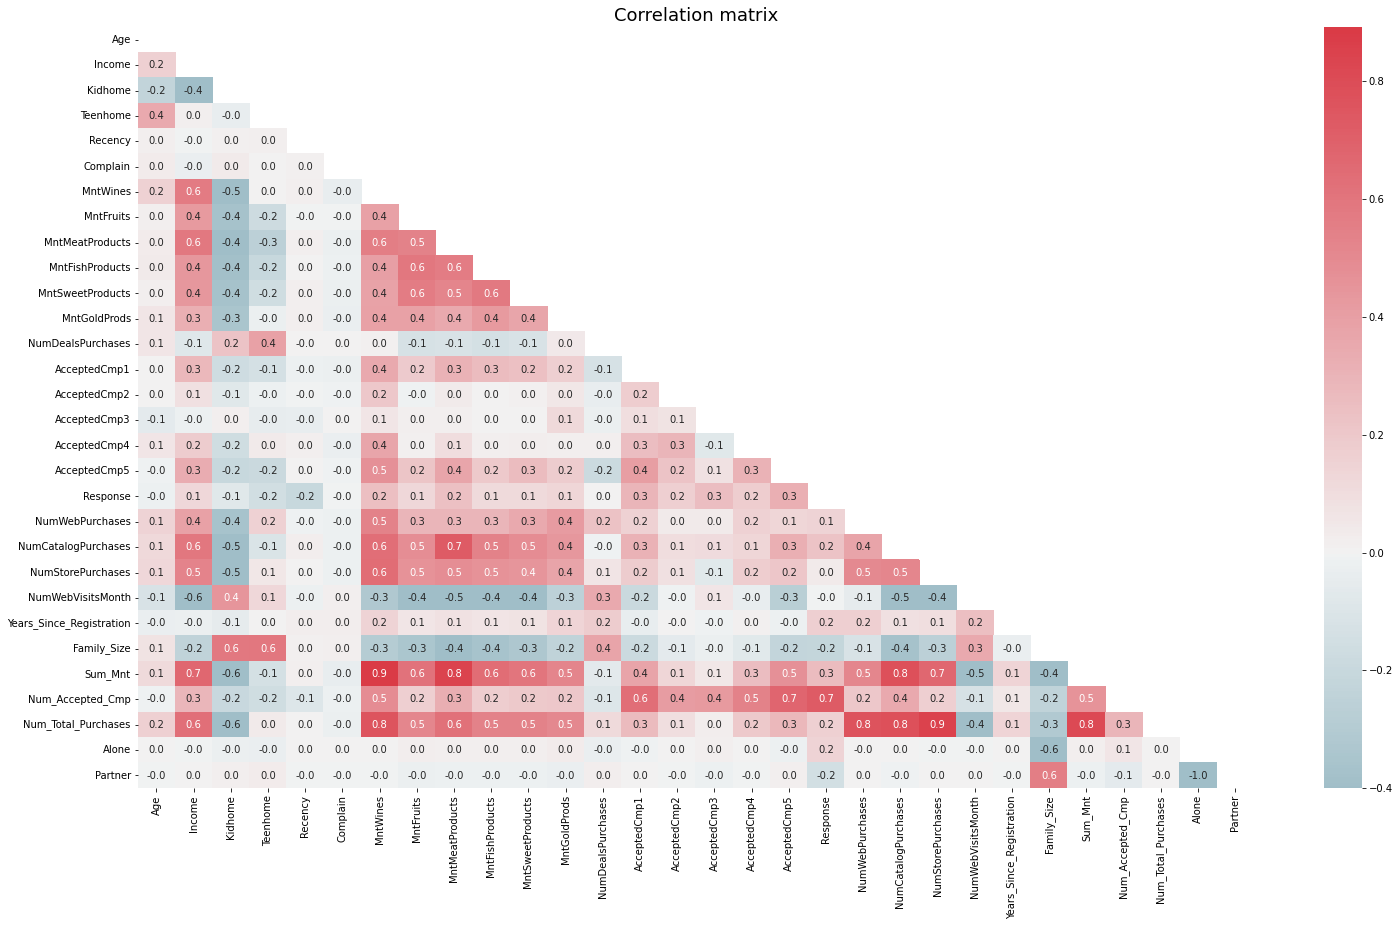

In [240]:
to_corr = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain', 
          'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
          'MntGoldProds', 'NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
          'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumWebPurchases', 'NumCatalogPurchases', 
          'NumStorePurchases', 'NumWebVisitsMonth', 'Years_Since_Registration', 'Family_Size',
           'Sum_Mnt', 'Num_Accepted_Cmp', 'Num_Total_Purchases', 'Alone', 'Partner']

cmap = sns.diverging_palette(220, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(25, 14))
plt.title('Correlation matrix', fontsize=18)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', vmin=-0.4, center=0, cmap=cmap, mask=matrix)

plt.show()


Distributions of quantitative variables:

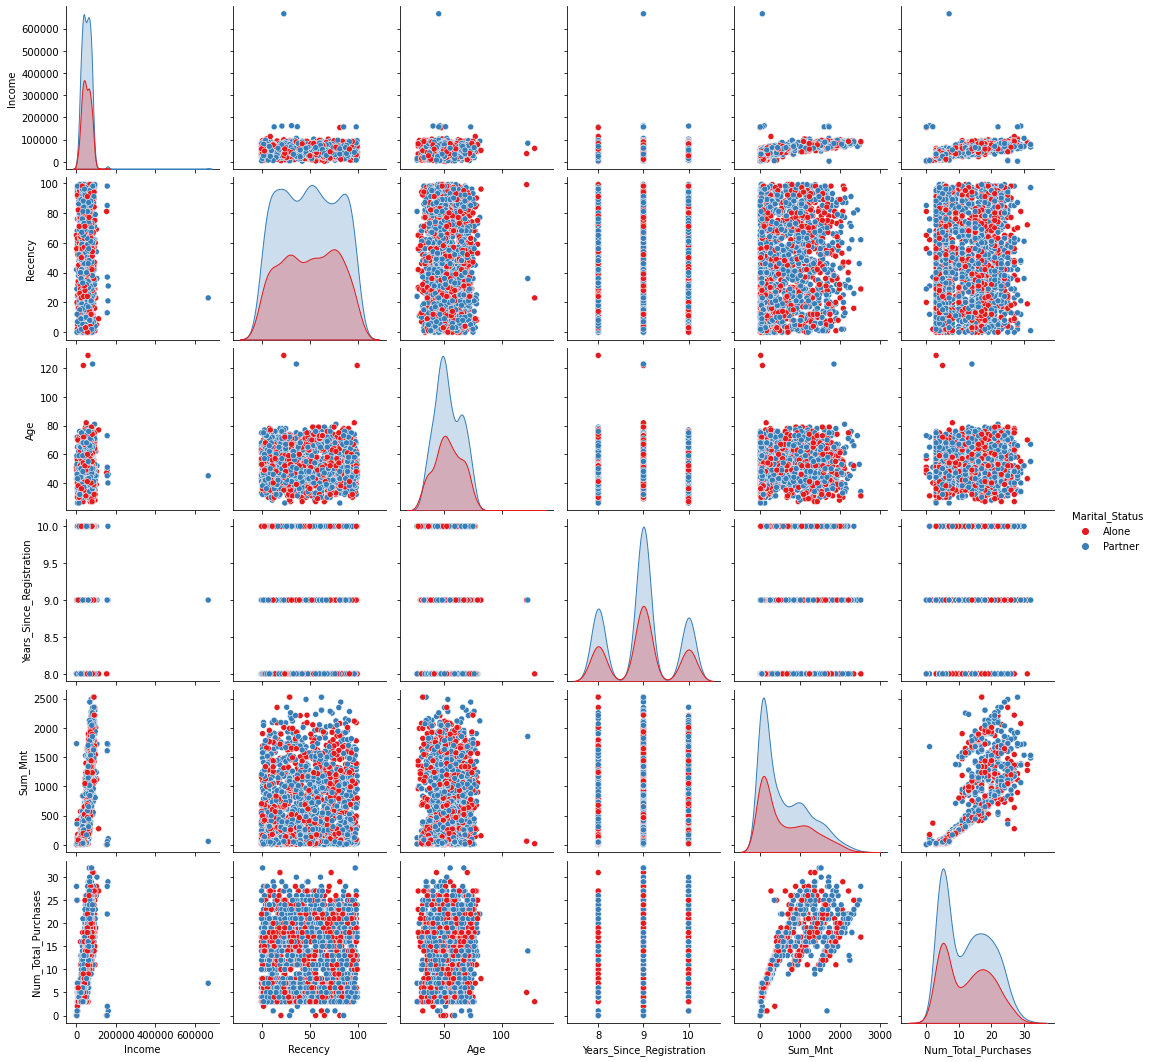

In [241]:
to_plot = ['Income', 'Recency', 'Age', 'Years_Since_Registration', 'Sum_Mnt',
           'Num_Total_Purchases', 'Marital_Status']
sns.pairplot(df[to_plot], hue='Marital_Status', palette='Set1')
plt.show()

DATA CLEANING

In [242]:
df.isna().sum()
df.dropna(inplace=True)  # Removed objects with gaps in income


Remove outliers in the data

In [243]:
def remove_outliers(data: pd.DataFrame, column: str) -> pd.Series:
    q3, q1 = np.nanpercentile(data[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data

df = remove_outliers(df, 'Age')
df = remove_outliers(df, 'Income')

Remove unnecessary features:

In [244]:
df.drop(['Year_Birth', 'ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer'], axis=1, inplace=True)

Elbow method to find optimum clusters

In [245]:
x1='Income'
x2='AcceptedCmp1'
#x3='Recency'
X = df.loc[:,[x1,x2]]

In [246]:
X

,Income,AcceptedCmp1
0,58138.0,0
1,46344.0,0
2,71613.0,0
3,26646.0,0
4,58293.0,0
...,...,...
2235,61223.0,0
2236,64014.0,1
2237,56981.0,0
2238,69245.0,0


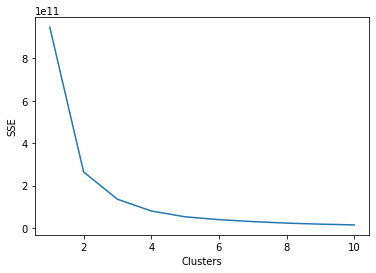

In [247]:
#elbow method
wcss = []
for i in range(1,11):
    k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X)
    wcss.append(k_means.inertia_)
#plot elbow curve
plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [248]:
k_means_optimum = KMeans(n_clusters = 2, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X)
print(y)

[0 1 0 ... 0 0 0]


In [249]:
data=X
data['cluster'] = y  
# the above step adds extra column indicating the cluster number for each country

In [250]:
data1 = data[data.cluster==0]
data2 = data[data.cluster==1]
data3 = data[data.cluster==2]


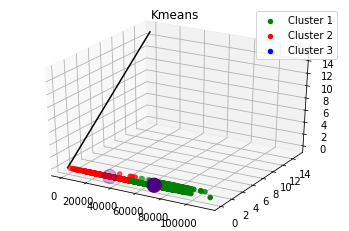

In [251]:
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
kplot.plot3D(xline, yline, zline, 'black')
# Data for three-dimensional scattered points
# kplot.scatter3D(data1.Teenhome, data1.Kidhome, data1.Response, c='red', label = 'Cluster 1')
# kplot.scatter3D(data2.Teenhome,data2.Kidhome,data2.Response,c ='green', label = 'Cluster 2')
# kplot.scatter3D(data3.Teenhome,data3.Kidhome,data3.Response,c ='green', label = 'Cluster 2')
kplot.scatter3D(data1[x1],data1[x2],c ='green', label = 'Cluster 1')
kplot.scatter3D(data2[x1],data2[x2],c ='red', label = 'Cluster 2')
kplot.scatter3D(data3[x1],data3[x2],c ='blue', label = 'Cluster 3')
plt.scatter(k_means_optimum.cluster_centers_[:,0], k_means_optimum.cluster_centers_[:,1], color = 'indigo', s = 200)
plt.legend()
plt.title("Kmeans")
plt.show()


In [252]:
unique, counts = np.unique(k_means_optimum.labels_, return_counts=True)
dict_data = dict(zip(unique, counts))
dict_data

{0: 1083, 1: 1122}

In [253]:
print(x1,x2)

Income AcceptedCmp1 Recency


In [254]:
arr =  [[178987,1]]


#np.reshape(arr, (1, -1))
k_means_optimum.predict(arr)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


array([0], dtype=int32)

In [255]:
data1

,Income,AcceptedCmp1,cluster
0,58138.0,0,0
2,71613.0,0,0
4,58293.0,0,0
5,62513.0,0,0
6,55635.0,0,0
...,...,...,...
2235,61223.0,0,0
2236,64014.0,1,0
2237,56981.0,0,0
2238,69245.0,0,0


In [256]:
data2

,Income,AcceptedCmp1,cluster
1,46344.0,0,1
3,26646.0,0,1
7,33454.0,0,1
8,30351.0,0,1
9,5648.0,0,1
...,...,...,...
2229,24434.0,0,1
2230,11012.0,0,1
2231,44802.0,0,1
2232,26816.0,0,1


In [270]:
print(data1['Income'].max())
print(data1['Income'].min())

print(data1.loc[data1['AcceptedCmp1']>0])
print(data1.loc[data1['AcceptedCmp1']==0])

113734.0
51948.0
       Income  AcceptedCmp1  cluster
15    82800.0             1        0
18    76995.0             1        0
53    82582.0             1        0
67    88194.0             1        0
98    78497.0             1        0
...       ...           ...      ...
2168  90000.0             1        0
2174  65210.0             1        0
2175  79174.0             1        0
2193  82347.0             1        0
2236  64014.0             1        0

[138 rows x 3 columns]
       Income  AcceptedCmp1  cluster
0     58138.0             0        0
2     71613.0             0        0
4     58293.0             0        0
5     62513.0             0        0
6     55635.0             0        0
...       ...           ...      ...
2227  57967.0             0        0
2235  61223.0             0        0
2237  56981.0             0        0
2238  69245.0             0        0
2239  52869.0             0        0

[945 rows x 3 columns]


In [271]:
print(data2['Income'].max())
print(data2['Income'].min())
print(data2.loc[data2['AcceptedCmp1']==1])
print(data2.loc[data2['AcceptedCmp1']==0])

51876.0
1730.0
       Income  AcceptedCmp1  cluster
87    50388.0             1        1
804   48192.0             1        1
854   46374.0             1        1
1670  37929.0             1        1
       Income  AcceptedCmp1  cluster
1     46344.0             0        1
3     26646.0             0        1
7     33454.0             0        1
8     30351.0             0        1
9      5648.0             0        1
...       ...           ...      ...
2229  24434.0             0        1
2230  11012.0             0        1
2231  44802.0             0        1
2232  26816.0             0        1
2234  34421.0             0        1

[1118 rows x 3 columns]
